In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.spectrum import (
    SpectrumDatasetOnOff,
    SpectrumDataset,
    SpectrumDatasetMaker,
)
from gammapy.modeling import Fit, Parameter
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SpectralModel,
    SkyModel,
    ExpCutoffPowerLawSpectralModel,
)
from gammapy.irf import load_cta_irfs
from gammapy.data import Observation
from gammapy.maps import MapAxis

In [3]:
livetime = 48 * u.h
pointing = SkyCoord(0, 0, unit="deg", frame="galactic")
offset = 0.5 * u.deg
# Reconstructed and true energy axis
energy_axis = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 10), unit="TeV", name="energy", interp="log"
)
energy_axis_true = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 31), unit="TeV", name="energy", interp="log"
)

on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=pointing, radius=on_region_radius)

In [4]:
# Define spectral model - a simple Power Law in this case
model_simu = ExpCutoffPowerLawSpectralModel(
    index=2.22,
    amplitude=1.289e-12 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1 * u.TeV,
    lambda_=1 * u.Unit("TeV-1"),
    alpha = 1,
)
print(model_simu)
# we set the sky model used in the dataset
model = SkyModel(spectral_model=model_simu)

ExpCutoffPowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.000e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True


In [5]:
os.environ['CALDB'] = '/home/rishank/anaconda2/envs/cta/share/caldb/'
!echo $CALDB
!ls $CALDB

/home/rishank/anaconda2/envs/cta/share/caldb/
data


In [6]:
# Load the IRFs
# In this simulation, we use the CTA-1DC irfs shipped with gammapy.
irfs = load_cta_irfs(
    "$CALDB/data/cta/prod3b-v2/bcf/South_z20_50h/irf_file.fits"
)

In [7]:
obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
print(obs)

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 172800.0 s



In [8]:
# Make the SpectrumDataset
dataset_empty = SpectrumDataset.create(
    e_reco=energy_axis.edges, e_true=energy_axis_true.edges, region=on_region
)
maker = SpectrumDatasetMaker(selection=["aeff", "edisp", "background"])
dataset = maker.run(dataset_empty, obs)

In [9]:
# Set the model on the dataset, and fake
dataset.model = model
dataset.fake(random_state=42)
print(dataset)

SpectrumDataset

    Name                            : 1 

    Total counts                    : 20280 
    Total predicted counts          : nan
    Total background counts         : 20309.41

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 1.73e+05 s

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : cash
    Fit statistic value (-2 log(L)) : nan

    Number of parameters            : 0
    Number of free parameters       : 0




In [10]:
dataset_onoff = SpectrumDatasetOnOff(
    aeff=dataset.aeff,
    edisp=dataset.edisp,
    models=model,
    livetime=livetime,
    acceptance=1,
    acceptance_off=5,
)
dataset_onoff.fake(background_model=dataset.background)
print(dataset_onoff)

SpectrumDatasetOnOff

    Name                            :  

    Total counts                    : 31626 
    Total predicted counts          : 31548.33
    Total off counts                : 101423.00

    Total background counts         : 20284.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.68

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0



In [11]:

%%time

n_obs = 5000
datasets = []

for idx in range(n_obs):
    dataset_onoff.fake(random_state=idx, background_model=dataset.background)
    dataset_onoff.name = f"obs_{idx}"
    datasets.append(dataset_onoff.copy())

CPU times: user 26.3 s, sys: 177 ms, total: 26.5 s
Wall time: 26.5 s


In [12]:
print(*datasets, sep = "\n") 

SpectrumDatasetOnOff

    Name                            : obs_0 

    Total counts                    : 31602 
    Total predicted counts          : 31630.33
    Total off counts                : 101833.00

    Total background counts         : 20366.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.37

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1 

    Total counts                    : 31506 
    Total predicted counts          : 31662.13
    Total off counts                : 101992.00

    Total background counts         : 2

SpectrumDatasetOnOff

    Name                            : obs_19 

    Total counts                    : 31565 
    Total predicted counts          : 31582.93
    Total off counts                : 101596.00

    Total background counts         : 20319.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.45

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_20 

    Total counts                    : 31719 
    Total predicted counts          : 31470.33
    Total off counts                : 101033.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_40 

    Total counts                    : 31415 
    Total predicted counts          : 31513.53
    Total off counts                : 101249.00

    Total background counts         : 20249.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.88

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_41 

    Total counts                    : 31234 
    Total predicted counts          : 31565.73
    Total off counts                : 101510.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_61 

    Total counts                    : 31957 
    Total predicted counts          : 31514.53
    Total off counts                : 101254.00

    Total background counts         : 20250.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.21

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_62 

    Total counts                    : 31689 
    Total predicted counts          : 31623.73
    Total off counts                : 101800.00

    Total background counts         :


SpectrumDatasetOnOff

    Name                            : obs_82 

    Total counts                    : 31276 
    Total predicted counts          : 31455.53
    Total off counts                : 100959.00

    Total background counts         : 20191.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.93

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_83 

    Total counts                    : 31589 
    Total predicted counts          : 31491.53
    Total off counts                : 101139.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_101 

    Total counts                    : 31645 
    Total predicted counts          : 31720.93
    Total off counts                : 102286.00

    Total background counts         : 20457.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.89

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_102 

    Total counts                    : 31373 
    Total predicted counts          : 31625.73
    Total off counts                : 101810.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_122 

    Total counts                    : 31336 
    Total predicted counts          : 31531.73
    Total off counts                : 101340.00

    Total background counts         : 20268.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.64

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_123 

    Total counts                    : 31507 
    Total predicted counts          : 31561.93
    Total off counts                : 101491.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_143 

    Total counts                    : 31151 
    Total predicted counts          : 31630.93
    Total off counts                : 101836.00

    Total background counts         : 20367.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 21.35

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_144 

    Total counts                    : 31506 
    Total predicted counts          : 31595.13
    Total off counts                : 101657.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_164 

    Total counts                    : 31499 
    Total predicted counts          : 31536.33
    Total off counts                : 101363.00

    Total background counts         : 20272.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.93

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_165 

    Total counts                    : 31571 
    Total predicted counts          : 31533.73
    Total off counts                : 101350.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_186 

    Total counts                    : 31686 
    Total predicted counts          : 31547.13
    Total off counts                : 101417.00

    Total background counts         : 20283.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.84

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_187 

    Total counts                    : 31333 
    Total predicted counts          : 31572.93
    Total off counts                : 101546.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_207 

    Total counts                    : 31483 
    Total predicted counts          : 31523.33
    Total off counts                : 101298.00

    Total background counts         : 20259.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.73

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_208 

    Total counts                    : 31301 
    Total predicted counts          : 31674.73
    Total off counts                : 102055.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_228 

    Total counts                    : 31770 
    Total predicted counts          : 31505.33
    Total off counts                : 101208.00

    Total background counts         : 20241.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.92

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_229 

    Total counts                    : 31657 
    Total predicted counts          : 31657.13
    Total off counts                : 101967.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_249 

    Total counts                    : 31741 
    Total predicted counts          : 31511.53
    Total off counts                : 101239.00

    Total background counts         : 20247.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.46

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_250 

    Total counts                    : 31897 
    Total predicted counts          : 31592.53
    Total off counts                : 101644.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_269 

    Total counts                    : 31506 
    Total predicted counts          : 31581.33
    Total off counts                : 101588.00

    Total background counts         : 20317.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.47

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_270 

    Total counts                    : 31423 
    Total predicted counts          : 31481.53
    Total off counts                : 101089.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_291 

    Total counts                    : 31431 
    Total predicted counts          : 31504.73
    Total off counts                : 101205.00

    Total background counts         : 20241.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.10

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_292 

    Total counts                    : 31456 
    Total predicted counts          : 31655.33
    Total off counts                : 101958.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_313 

    Total counts                    : 31350 
    Total predicted counts          : 31561.53
    Total off counts                : 101489.00

    Total background counts         : 20297.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.01

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_314 

    Total counts                    : 31737 
    Total predicted counts          : 31499.13
    Total off counts                : 101177.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_335 

    Total counts                    : 31649 
    Total predicted counts          : 31493.73
    Total off counts                : 101150.00

    Total background counts         : 20230.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.73

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_336 

    Total counts                    : 31688 
    Total predicted counts          : 31601.93
    Total off counts                : 101691.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_357 

    Total counts                    : 31539 
    Total predicted counts          : 31552.53
    Total off counts                : 101444.00

    Total background counts         : 20288.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.45

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_358 

    Total counts                    : 31334 
    Total predicted counts          : 31443.53
    Total off counts                : 100899.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_378 

    Total counts                    : 31543 
    Total predicted counts          : 31488.93
    Total off counts                : 101126.00

    Total background counts         : 20225.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.01

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_379 

    Total counts                    : 31590 
    Total predicted counts          : 31595.93
    Total off counts                : 101661.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_399 

    Total counts                    : 31624 
    Total predicted counts          : 31548.93
    Total off counts                : 101426.00

    Total background counts         : 20285.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.88

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_400 

    Total counts                    : 31716 
    Total predicted counts          : 31621.93
    Total off counts                : 101791.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_420 

    Total counts                    : 31280 
    Total predicted counts          : 31530.53
    Total off counts                : 101334.00

    Total background counts         : 20266.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.36

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_421 

    Total counts                    : 31753 
    Total predicted counts          : 31633.93
    Total off counts                : 101851.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_442 

    Total counts                    : 31438 
    Total predicted counts          : 31604.13
    Total off counts                : 101702.00

    Total background counts         : 20340.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.66

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_443 

    Total counts                    : 31422 
    Total predicted counts          : 31559.53
    Total off counts                : 101479.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_464 

    Total counts                    : 31509 
    Total predicted counts          : 31556.73
    Total off counts                : 101465.00

    Total background counts         : 20293.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.74

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_465 

    Total counts                    : 31569 
    Total predicted counts          : 31509.73
    Total off counts                : 101230.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_486 

    Total counts                    : 31537 
    Total predicted counts          : 31588.93
    Total off counts                : 101626.00

    Total background counts         : 20325.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.87

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_487 

    Total counts                    : 31659 
    Total predicted counts          : 31459.93
    Total off counts                : 100981.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_507 

    Total counts                    : 31317 
    Total predicted counts          : 31562.53
    Total off counts                : 101494.00

    Total background counts         : 20298.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.03

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_508 

    Total counts                    : 31823 
    Total predicted counts          : 31614.73
    Total off counts                : 101755.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_528 

    Total counts                    : 31773 
    Total predicted counts          : 31597.53
    Total off counts                : 101669.00

    Total background counts         : 20333.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.95

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_529 

    Total counts                    : 31477 
    Total predicted counts          : 31526.93
    Total off counts                : 101316.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_549 

    Total counts                    : 31522 
    Total predicted counts          : 31578.73
    Total off counts                : 101575.00

    Total background counts         : 20315.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.99

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_550 

    Total counts                    : 31139 
    Total predicted counts          : 31510.93
    Total off counts                : 101236.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_570 

    Total counts                    : 31960 
    Total predicted counts          : 31598.53
    Total off counts                : 101674.00

    Total background counts         : 20334.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.33

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_571 

    Total counts                    : 31416 
    Total predicted counts          : 31647.53
    Total off counts                : 101919.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_591 

    Total counts                    : 31621 
    Total predicted counts          : 31631.33
    Total off counts                : 101838.00

    Total background counts         : 20367.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.40

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_592 

    Total counts                    : 31668 
    Total predicted counts          : 31573.53
    Total off counts                : 101549.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_612 

    Total counts                    : 31737 
    Total predicted counts          : 31596.33
    Total off counts                : 101663.00

    Total background counts         : 20332.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.53

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_613 

    Total counts                    : 31540 
    Total predicted counts          : 31551.13
    Total off counts                : 101437.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_633 

    Total counts                    : 31523 
    Total predicted counts          : 31578.73
    Total off counts                : 101575.00

    Total background counts         : 20315.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.15

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_634 

    Total counts                    : 31909 
    Total predicted counts          : 31645.33
    Total off counts                : 101908.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_654 

    Total counts                    : 31779 
    Total predicted counts          : 31611.33
    Total off counts                : 101738.00

    Total background counts         : 20347.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.78

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_655 

    Total counts                    : 31687 
    Total predicted counts          : 31585.73
    Total off counts                : 101610.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_675 

    Total counts                    : 31484 
    Total predicted counts          : 31636.53
    Total off counts                : 101864.00

    Total background counts         : 20372.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.15

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_676 

    Total counts                    : 31865 
    Total predicted counts          : 31543.93
    Total off counts                : 101401.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_696 

    Total counts                    : 31447 
    Total predicted counts          : 31591.73
    Total off counts                : 101640.00

    Total background counts         : 20328.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.66

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_697 

    Total counts                    : 31373 
    Total predicted counts          : 31554.53
    Total off counts                : 101454.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_717 

    Total counts                    : 31718 
    Total predicted counts          : 31594.93
    Total off counts                : 101656.00

    Total background counts         : 20331.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.78

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_718 

    Total counts                    : 31626 
    Total predicted counts          : 31598.33
    Total off counts                : 101673.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_728 

    Total counts                    : 31744 
    Total predicted counts          : 31516.33
    Total off counts                : 101263.00

    Total background counts         : 20252.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.47

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_729 

    Total counts                    : 31651 
    Total predicted counts          : 31571.73
    Total off counts                : 101540.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_749 

    Total counts                    : 31244 
    Total predicted counts          : 31597.33
    Total off counts                : 101668.00

    Total background counts         : 20333.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.76

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_750 

    Total counts                    : 31702 
    Total predicted counts          : 31547.13
    Total off counts                : 101417.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_770 

    Total counts                    : 31700 
    Total predicted counts          : 31567.93
    Total off counts                : 101521.00

    Total background counts         : 20304.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.35

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_771 

    Total counts                    : 31782 
    Total predicted counts          : 31584.13
    Total off counts                : 101602.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_790 

    Total counts                    : 31737 
    Total predicted counts          : 31528.53
    Total off counts                : 101324.00

    Total background counts         : 20264.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.41

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_791 

    Total counts                    : 31729 
    Total predicted counts          : 31495.33
    Total off counts                : 101158.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_810 

    Total counts                    : 31760 
    Total predicted counts          : 31671.53
    Total off counts                : 102039.00

    Total background counts         : 20407.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.23

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_811 

    Total counts                    : 31554 
    Total predicted counts          : 31592.33
    Total off counts                : 101643.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_831 

    Total counts                    : 31470 
    Total predicted counts          : 31553.33
    Total off counts                : 101448.00

    Total background counts         : 20289.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.26

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_832 

    Total counts                    : 31964 
    Total predicted counts          : 31542.13
    Total off counts                : 101392.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_842 

    Total counts                    : 31560 
    Total predicted counts          : 31563.13
    Total off counts                : 101497.00

    Total background counts         : 20299.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.45

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_843 

    Total counts                    : 31814 
    Total predicted counts          : 31668.73
    Total off counts                : 102025.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_864 

    Total counts                    : 31586 
    Total predicted counts          : 31615.53
    Total off counts                : 101759.00

    Total background counts         : 20351.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.85

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_865 

    Total counts                    : 31576 
    Total predicted counts          : 31677.73
    Total off counts                : 102070.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_888 

    Total counts                    : 31687 
    Total predicted counts          : 31590.33
    Total off counts                : 101633.00

    Total background counts         : 20326.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.04

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_889 

    Total counts                    : 31542 
    Total predicted counts          : 31457.53
    Total off counts                : 100969.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_903 

    Total counts                    : 31475 
    Total predicted counts          : 31582.53
    Total off counts                : 101594.00

    Total background counts         : 20318.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.76

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_904 

    Total counts                    : 31370 
    Total predicted counts          : 31571.53
    Total off counts                : 101539.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_921 

    Total counts                    : 31894 
    Total predicted counts          : 31603.73
    Total off counts                : 101700.00

    Total background counts         : 20340.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.30

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_922 

    Total counts                    : 31716 
    Total predicted counts          : 31599.93
    Total off counts                : 101681.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_935 

    Total counts                    : 31573 
    Total predicted counts          : 31614.33
    Total off counts                : 101753.00

    Total background counts         : 20350.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.70

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_936 

    Total counts                    : 31786 
    Total predicted counts          : 31645.53
    Total off counts                : 101909.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_953 

    Total counts                    : 31706 
    Total predicted counts          : 31429.33
    Total off counts                : 100828.00

    Total background counts         : 20165.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.65

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_954 

    Total counts                    : 31476 
    Total predicted counts          : 31604.73
    Total off counts                : 101705.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_968 

    Total counts                    : 31456 
    Total predicted counts          : 31577.53
    Total off counts                : 101569.00

    Total background counts         : 20313.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.48

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_969 

    Total counts                    : 31296 
    Total predicted counts          : 31621.33
    Total off counts                : 101788.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_985 

    Total counts                    : 31264 
    Total predicted counts          : 31599.53
    Total off counts                : 101679.00

    Total background counts         : 20335.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.70

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_986 

    Total counts                    : 31686 
    Total predicted counts          : 31601.93
    Total off counts                : 101691.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_999 

    Total counts                    : 31447 
    Total predicted counts          : 31501.53
    Total off counts                : 101189.00

    Total background counts         : 20237.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.28

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1000 

    Total counts                    : 31515 
    Total predicted counts          : 31480.93
    Total off counts                : 101086.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_1017 

    Total counts                    : 31272 
    Total predicted counts          : 31663.33
    Total off counts                : 101998.00

    Total background counts         : 20399.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.60

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1018 

    Total counts                    : 31361 
    Total predicted counts          : 31477.33
    Total off counts                : 101068.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1031 

    Total counts                    : 31385 
    Total predicted counts          : 31514.53
    Total off counts                : 101254.00

    Total background counts         : 20250.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.04

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1032 

    Total counts                    : 31653 
    Total predicted counts          : 31579.13
    Total off counts                : 101577.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1049 

    Total counts                    : 31774 
    Total predicted counts          : 31770.13
    Total off counts                : 102532.00

    Total background counts         : 20506.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.02

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1050 

    Total counts                    : 31686 
    Total predicted counts          : 31559.13
    Total off counts                : 101477.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_1064 

    Total counts                    : 31614 
    Total predicted counts          : 31701.13
    Total off counts                : 102187.00

    Total background counts         : 20437.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.90

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1065 

    Total counts                    : 31298 
    Total predicted counts          : 31436.53
    Total off counts                : 100864.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1085 

    Total counts                    : 31903 
    Total predicted counts          : 31554.33
    Total off counts                : 101453.00

    Total background counts         : 20290.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.97

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1086 

    Total counts                    : 31731 
    Total predicted counts          : 31627.53
    Total off counts                : 101819.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1103 

    Total counts                    : 31611 
    Total predicted counts          : 31632.73
    Total off counts                : 101845.00

    Total background counts         : 20369.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.61

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1104 

    Total counts                    : 31612 
    Total predicted counts          : 31532.33
    Total off counts                : 101343.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1118 

    Total counts                    : 31724 
    Total predicted counts          : 31591.93
    Total off counts                : 101641.00

    Total background counts         : 20328.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.90

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1119 

    Total counts                    : 31364 
    Total predicted counts          : 31552.73
    Total off counts                : 101445.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1136 

    Total counts                    : 31849 
    Total predicted counts          : 31522.93
    Total off counts                : 101296.00

    Total background counts         : 20259.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.84

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1137 

    Total counts                    : 31839 
    Total predicted counts          : 31672.13
    Total off counts                : 102042.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1150 

    Total counts                    : 31953 
    Total predicted counts          : 31564.93
    Total off counts                : 101506.00

    Total background counts         : 20301.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.51

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1151 

    Total counts                    : 31626 
    Total predicted counts          : 31556.73
    Total off counts                : 101465.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1169 

    Total counts                    : 31341 
    Total predicted counts          : 31543.13
    Total off counts                : 101397.00

    Total background counts         : 20279.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.68

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1170 

    Total counts                    : 31741 
    Total predicted counts          : 31512.73
    Total off counts                : 101245.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1184 

    Total counts                    : 31700 
    Total predicted counts          : 31615.13
    Total off counts                : 101757.00

    Total background counts         : 20351.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.78

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1185 

    Total counts                    : 31592 
    Total predicted counts          : 31596.13
    Total off counts                : 101662.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1204 

    Total counts                    : 31703 
    Total predicted counts          : 31505.93
    Total off counts                : 101211.00

    Total background counts         : 20242.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.38

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1205 

    Total counts                    : 31599 
    Total predicted counts          : 31613.13
    Total off counts                : 101747.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1218 

    Total counts                    : 31678 
    Total predicted counts          : 31596.93
    Total off counts                : 101666.00

    Total background counts         : 20333.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.47

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1219 

    Total counts                    : 31565 
    Total predicted counts          : 31577.13
    Total off counts                : 101567.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1236 

    Total counts                    : 31436 
    Total predicted counts          : 31575.93
    Total off counts                : 101561.00

    Total background counts         : 20312.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.77

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1237 

    Total counts                    : 31399 
    Total predicted counts          : 31639.13
    Total off counts                : 101877.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1252 

    Total counts                    : 31500 
    Total predicted counts          : 31523.33
    Total off counts                : 101298.00

    Total background counts         : 20259.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.18

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1253 

    Total counts                    : 31528 
    Total predicted counts          : 31595.93
    Total off counts                : 101661.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1268 

    Total counts                    : 31235 
    Total predicted counts          : 31625.73
    Total off counts                : 101810.00

    Total background counts         : 20362.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 18.33

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1269 

    Total counts                    : 31522 
    Total predicted counts          : 31572.33
    Total off counts                : 101543.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1285 

    Total counts                    : 31281 
    Total predicted counts          : 31659.73
    Total off counts                : 101980.00

    Total background counts         : 20396.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.57

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1286 

    Total counts                    : 31675 
    Total predicted counts          : 31623.53
    Total off counts                : 101799.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1300 

    Total counts                    : 31457 
    Total predicted counts          : 31633.93
    Total off counts                : 101851.00

    Total background counts         : 20370.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.77

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1301 

    Total counts                    : 31608 
    Total predicted counts          : 31590.73
    Total off counts                : 101635.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1317 

    Total counts                    : 31779 
    Total predicted counts          : 31571.13
    Total off counts                : 101537.00

    Total background counts         : 20307.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.86

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1318 

    Total counts                    : 31365 
    Total predicted counts          : 31622.73
    Total off counts                : 101795.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1331 

    Total counts                    : 31938 
    Total predicted counts          : 31584.53
    Total off counts                : 101604.00

    Total background counts         : 20320.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.09

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1332 

    Total counts                    : 31431 
    Total predicted counts          : 31571.53
    Total off counts                : 101539.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1351 

    Total counts                    : 31578 
    Total predicted counts          : 31527.73
    Total off counts                : 101320.00

    Total background counts         : 20264.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.71

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1352 

    Total counts                    : 31504 
    Total predicted counts          : 31509.73
    Total off counts                : 101230.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1364 

    Total counts                    : 31159 
    Total predicted counts          : 31413.93
    Total off counts                : 100751.00

    Total background counts         : 20150.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.68

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1365 

    Total counts                    : 31657 
    Total predicted counts          : 31540.53
    Total off counts                : 101384.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1382 

    Total counts                    : 31264 
    Total predicted counts          : 31478.93
    Total off counts                : 101076.00

    Total background counts         : 20215.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.22

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1383 

    Total counts                    : 31730 
    Total predicted counts          : 31537.33
    Total off counts                : 101368.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1396 

    Total counts                    : 31295 
    Total predicted counts          : 31591.93
    Total off counts                : 101641.00

    Total background counts         : 20328.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.28

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1397 

    Total counts                    : 31533 
    Total predicted counts          : 31641.33
    Total off counts                : 101888.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1412 

    Total counts                    : 31616 
    Total predicted counts          : 31593.73
    Total off counts                : 101650.00

    Total background counts         : 20330.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.46

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1413 

    Total counts                    : 31024 
    Total predicted counts          : 31670.53
    Total off counts                : 102034.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1426 

    Total counts                    : 31716 
    Total predicted counts          : 31595.13
    Total off counts                : 101657.00

    Total background counts         : 20331.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.07

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1427 

    Total counts                    : 31647 
    Total predicted counts          : 31548.93
    Total off counts                : 101426.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1444 

    Total counts                    : 31783 
    Total predicted counts          : 31536.33
    Total off counts                : 101363.00

    Total background counts         : 20272.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.56

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1445 

    Total counts                    : 31806 
    Total predicted counts          : 31561.93
    Total off counts                : 101491.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1458 

    Total counts                    : 31998 
    Total predicted counts          : 31554.13
    Total off counts                : 101452.00

    Total background counts         : 20290.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.49

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1459 

    Total counts                    : 31681 
    Total predicted counts          : 31495.93
    Total off counts                : 101161.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1477 

    Total counts                    : 31563 
    Total predicted counts          : 31476.73
    Total off counts                : 101065.00

    Total background counts         : 20213.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.44

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1478 

    Total counts                    : 31758 
    Total predicted counts          : 31546.53
    Total off counts                : 101414.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1491 

    Total counts                    : 31505 
    Total predicted counts          : 31518.13
    Total off counts                : 101272.00

    Total background counts         : 20254.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.95

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1492 

    Total counts                    : 31427 
    Total predicted counts          : 31484.33
    Total off counts                : 101103.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1510 

    Total counts                    : 31375 
    Total predicted counts          : 31495.73
    Total off counts                : 101160.00

    Total background counts         : 20232.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 0.77

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1511 

    Total counts                    : 31465 
    Total predicted counts          : 31521.73
    Total off counts                : 101290.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1523 

    Total counts                    : 31497 
    Total predicted counts          : 31593.33
    Total off counts                : 101648.00

    Total background counts         : 20329.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.17

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1524 

    Total counts                    : 31568 
    Total predicted counts          : 31633.73
    Total off counts                : 101850.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1542 

    Total counts                    : 31276 
    Total predicted counts          : 31568.53
    Total off counts                : 101524.00

    Total background counts         : 20304.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.74

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1543 

    Total counts                    : 32050 
    Total predicted counts          : 31704.13
    Total off counts                : 102202.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1554 

    Total counts                    : 31954 
    Total predicted counts          : 31655.33
    Total off counts                : 101958.00

    Total background counts         : 20391.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.19

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1555 

    Total counts                    : 31477 
    Total predicted counts          : 31538.33
    Total off counts                : 101373.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1573 

    Total counts                    : 31722 
    Total predicted counts          : 31599.53
    Total off counts                : 101679.00

    Total background counts         : 20335.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.96

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1574 

    Total counts                    : 31662 
    Total predicted counts          : 31556.73
    Total off counts                : 101465.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1584 

    Total counts                    : 31340 
    Total predicted counts          : 31611.53
    Total off counts                : 101739.00

    Total background counts         : 20347.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.02

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1585 

    Total counts                    : 31574 
    Total predicted counts          : 31603.13
    Total off counts                : 101697.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1605 

    Total counts                    : 31983 
    Total predicted counts          : 31659.33
    Total off counts                : 101978.00

    Total background counts         : 20395.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.29

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1606 

    Total counts                    : 31687 
    Total predicted counts          : 31583.93
    Total off counts                : 101601.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1632 

    Total counts                    : 31505 
    Total predicted counts          : 31515.33
    Total off counts                : 101258.00

    Total background counts         : 20251.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 26.36

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1633 

    Total counts                    : 31461 
    Total predicted counts          : 31668.73
    Total off counts                : 102025.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1643 

    Total counts                    : 31521 
    Total predicted counts          : 31565.73
    Total off counts                : 101510.00

    Total background counts         : 20302.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 15.77

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1644 

    Total counts                    : 31571 
    Total predicted counts          : 31591.93
    Total off counts                : 101641.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1663 

    Total counts                    : 32164 
    Total predicted counts          : 31539.93
    Total off counts                : 101381.00

    Total background counts         : 20276.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 15.92

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1664 

    Total counts                    : 31725 
    Total predicted counts          : 31531.33
    Total off counts                : 101338.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1683 

    Total counts                    : 31480 
    Total predicted counts          : 31537.33
    Total off counts                : 101368.00

    Total background counts         : 20273.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.85

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1684 

    Total counts                    : 31497 
    Total predicted counts          : 31615.93
    Total off counts                : 101761.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1711 

    Total counts                    : 31671 
    Total predicted counts          : 31588.93
    Total off counts                : 101626.00

    Total background counts         : 20325.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.42

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1712 

    Total counts                    : 31607 
    Total predicted counts          : 31559.73
    Total off counts                : 101480.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1745 

    Total counts                    : 31637 
    Total predicted counts          : 31579.13
    Total off counts                : 101577.00

    Total background counts         : 20315.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.70

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1746 

    Total counts                    : 31805 
    Total predicted counts          : 31687.93
    Total off counts                : 102121.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1779 

    Total counts                    : 31582 
    Total predicted counts          : 31490.73
    Total off counts                : 101135.00

    Total background counts         : 20227.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.76

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1780 

    Total counts                    : 31509 
    Total predicted counts          : 31541.33
    Total off counts                : 101388.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1814 

    Total counts                    : 31845 
    Total predicted counts          : 31561.93
    Total off counts                : 101491.00

    Total background counts         : 20298.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.16

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1815 

    Total counts                    : 31335 
    Total predicted counts          : 31563.73
    Total off counts                : 101500.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1850 

    Total counts                    : 31201 
    Total predicted counts          : 31577.53
    Total off counts                : 101569.00

    Total background counts         : 20313.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.41

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1851 

    Total counts                    : 31732 
    Total predicted counts          : 31488.93
    Total off counts                : 101126.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1884 

    Total counts                    : 31657 
    Total predicted counts          : 31525.53
    Total off counts                : 101309.00

    Total background counts         : 20261.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.90

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1885 

    Total counts                    : 31346 
    Total predicted counts          : 31677.53
    Total off counts                : 102069.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1918 

    Total counts                    : 31585 
    Total predicted counts          : 31591.33
    Total off counts                : 101638.00

    Total background counts         : 20327.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.17

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1919 

    Total counts                    : 31452 
    Total predicted counts          : 31632.13
    Total off counts                : 101842.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1952 

    Total counts                    : 31433 
    Total predicted counts          : 31501.33
    Total off counts                : 101188.00

    Total background counts         : 20237.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.66

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1953 

    Total counts                    : 31594 
    Total predicted counts          : 31656.53
    Total off counts                : 101964.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1986 

    Total counts                    : 31617 
    Total predicted counts          : 31478.73
    Total off counts                : 101075.00

    Total background counts         : 20215.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.95

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1987 

    Total counts                    : 31341 
    Total predicted counts          : 31474.93
    Total off counts                : 101056.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2021 

    Total counts                    : 31315 
    Total predicted counts          : 31549.73
    Total off counts                : 101430.00

    Total background counts         : 20286.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.42

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2022 

    Total counts                    : 31464 
    Total predicted counts          : 31705.13
    Total off counts                : 102207.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2054 

    Total counts                    : 32128 
    Total predicted counts          : 31565.93
    Total off counts                : 101511.00

    Total background counts         : 20302.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.74

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2055 

    Total counts                    : 31622 
    Total predicted counts          : 31642.33
    Total off counts                : 101893.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2086 

    Total counts                    : 31551 
    Total predicted counts          : 31505.33
    Total off counts                : 101208.00

    Total background counts         : 20241.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.01

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2087 

    Total counts                    : 31599 
    Total predicted counts          : 31501.93
    Total off counts                : 101191.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2120 

    Total counts                    : 31352 
    Total predicted counts          : 31442.13
    Total off counts                : 100892.00

    Total background counts         : 20178.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.33

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2121 

    Total counts                    : 31483 
    Total predicted counts          : 31458.13
    Total off counts                : 100972.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2153 

    Total counts                    : 31843 
    Total predicted counts          : 31545.53
    Total off counts                : 101409.00

    Total background counts         : 20281.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.23

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2154 

    Total counts                    : 31276 
    Total predicted counts          : 31621.13
    Total off counts                : 101787.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2187 

    Total counts                    : 31591 
    Total predicted counts          : 31573.93
    Total off counts                : 101551.00

    Total background counts         : 20310.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.47

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2188 

    Total counts                    : 31758 
    Total predicted counts          : 31648.53
    Total off counts                : 101924.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2219 

    Total counts                    : 31240 
    Total predicted counts          : 31492.13
    Total off counts                : 101142.00

    Total background counts         : 20228.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.70

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2220 

    Total counts                    : 31685 
    Total predicted counts          : 31552.53
    Total off counts                : 101444.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2251 

    Total counts                    : 31664 
    Total predicted counts          : 31590.93
    Total off counts                : 101636.00

    Total background counts         : 20327.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.78

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2252 

    Total counts                    : 31778 
    Total predicted counts          : 31620.93
    Total off counts                : 101786.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2286 

    Total counts                    : 31698 
    Total predicted counts          : 31574.13
    Total off counts                : 101552.00

    Total background counts         : 20310.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.27

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2287 

    Total counts                    : 31536 
    Total predicted counts          : 31646.73
    Total off counts                : 101915.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_2307 

    Total counts                    : 31813 
    Total predicted counts          : 31591.93
    Total off counts                : 101641.00

    Total background counts         : 20328.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.62

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2308 

    Total counts                    : 31569 
    Total predicted counts          : 31584.73
    Total off counts                : 101605.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2325 

    Total counts                    : 31562 
    Total predicted counts          : 31627.93
    Total off counts                : 101821.00

    Total background counts         : 20364.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.20

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2326 

    Total counts                    : 31674 
    Total predicted counts          : 31591.53
    Total off counts                : 101639.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2345 

    Total counts                    : 31847 
    Total predicted counts          : 31487.13
    Total off counts                : 101117.00

    Total background counts         : 20223.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.61

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2346 

    Total counts                    : 31488 
    Total predicted counts          : 31526.73
    Total off counts                : 101315.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2365 

    Total counts                    : 31449 
    Total predicted counts          : 31570.53
    Total off counts                : 101534.00

    Total background counts         : 20306.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.64

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2366 

    Total counts                    : 31311 
    Total predicted counts          : 31716.13
    Total off counts                : 102262.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2386 

    Total counts                    : 31302 
    Total predicted counts          : 31636.53
    Total off counts                : 101864.00

    Total background counts         : 20372.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.51

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2387 

    Total counts                    : 31582 
    Total predicted counts          : 31583.93
    Total off counts                : 101601.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2407 

    Total counts                    : 31678 
    Total predicted counts          : 31626.73
    Total off counts                : 101815.00

    Total background counts         : 20363.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.84

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2408 

    Total counts                    : 31488 
    Total predicted counts          : 31507.93
    Total off counts                : 101221.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2433 

    Total counts                    : 31468 
    Total predicted counts          : 31591.33
    Total off counts                : 101638.00

    Total background counts         : 20327.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.03

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2434 

    Total counts                    : 31670 
    Total predicted counts          : 31614.93
    Total off counts                : 101756.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2460 

    Total counts                    : 31479 
    Total predicted counts          : 31500.33
    Total off counts                : 101183.00

    Total background counts         : 20236.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.98

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2461 

    Total counts                    : 31763 
    Total predicted counts          : 31492.13
    Total off counts                : 101142.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2485 

    Total counts                    : 31683 
    Total predicted counts          : 31541.33
    Total off counts                : 101388.00

    Total background counts         : 20277.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.20

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2486 

    Total counts                    : 31534 
    Total predicted counts          : 31445.73
    Total off counts                : 100910.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2505 

    Total counts                    : 31460 
    Total predicted counts          : 31578.53
    Total off counts                : 101574.00

    Total background counts         : 20314.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.90

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2506 

    Total counts                    : 31768 
    Total predicted counts          : 31571.73
    Total off counts                : 101540.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2526 

    Total counts                    : 31210 
    Total predicted counts          : 31608.93
    Total off counts                : 101726.00

    Total background counts         : 20345.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.93

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2527 

    Total counts                    : 31869 
    Total predicted counts          : 31545.33
    Total off counts                : 101408.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_2548 

    Total counts                    : 31507 
    Total predicted counts          : 31606.73
    Total off counts                : 101715.00

    Total background counts         : 20343.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.85

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2549 

    Total counts                    : 31628 
    Total predicted counts          : 31547.33
    Total off counts                : 101418.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2568 

    Total counts                    : 32005 
    Total predicted counts          : 31574.13
    Total off counts                : 101552.00

    Total background counts         : 20310.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.44

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2569 

    Total counts                    : 31762 
    Total predicted counts          : 31718.53
    Total off counts                : 102274.00

    Total background counts      


SpectrumDatasetOnOff

    Name                            : obs_2590 

    Total counts                    : 31678 
    Total predicted counts          : 31575.13
    Total off counts                : 101557.00

    Total background counts         : 20311.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.31

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2591 

    Total counts                    : 31962 
    Total predicted counts          : 31591.13
    Total off counts                : 101637.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2610 

    Total counts                    : 31326 
    Total predicted counts          : 31622.53
    Total off counts                : 101794.00

    Total background counts         : 20358.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.03

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2611 

    Total counts                    : 31927 
    Total predicted counts          : 31649.73
    Total off counts                : 101930.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2631 

    Total counts                    : 31664 
    Total predicted counts          : 31666.93
    Total off counts                : 102016.00

    Total background counts         : 20403.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.79

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2632 

    Total counts                    : 31997 
    Total predicted counts          : 31652.53
    Total off counts                : 101944.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2653 

    Total counts                    : 31838 
    Total predicted counts          : 31680.93
    Total off counts                : 102086.00

    Total background counts         : 20417.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.52

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2654 

    Total counts                    : 31598 
    Total predicted counts          : 31550.93
    Total off counts                : 101436.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_2675 

    Total counts                    : 31420 
    Total predicted counts          : 31645.13
    Total off counts                : 101907.00

    Total background counts         : 20381.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.63

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2676 

    Total counts                    : 31303 
    Total predicted counts          : 31543.73
    Total off counts                : 101400.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2695 

    Total counts                    : 31561 
    Total predicted counts          : 31584.93
    Total off counts                : 101606.00

    Total background counts         : 20321.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.60

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2696 

    Total counts                    : 31644 
    Total predicted counts          : 31522.73
    Total off counts                : 101295.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2716 

    Total counts                    : 31573 
    Total predicted counts          : 31556.73
    Total off counts                : 101465.00

    Total background counts         : 20293.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.00

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2717 

    Total counts                    : 31407 
    Total predicted counts          : 31572.13
    Total off counts                : 101542.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2737 

    Total counts                    : 31429 
    Total predicted counts          : 31495.53
    Total off counts                : 101159.00

    Total background counts         : 20231.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.94

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2738 

    Total counts                    : 31715 
    Total predicted counts          : 31549.93
    Total off counts                : 101431.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2758 

    Total counts                    : 31460 
    Total predicted counts          : 31517.53
    Total off counts                : 101269.00

    Total background counts         : 20253.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.45

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2759 

    Total counts                    : 31629 
    Total predicted counts          : 31521.33
    Total off counts                : 101288.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2779 

    Total counts                    : 31165 
    Total predicted counts          : 31592.53
    Total off counts                : 101644.00

    Total background counts         : 20328.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.77

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2780 

    Total counts                    : 31500 
    Total predicted counts          : 31628.13
    Total off counts                : 101822.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2800 

    Total counts                    : 31217 
    Total predicted counts          : 31588.53
    Total off counts                : 101624.00

    Total background counts         : 20324.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.95

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2801 

    Total counts                    : 31545 
    Total predicted counts          : 31555.33
    Total off counts                : 101458.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2822 

    Total counts                    : 31650 
    Total predicted counts          : 31508.33
    Total off counts                : 101223.00

    Total background counts         : 20244.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.77

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2823 

    Total counts                    : 31773 
    Total predicted counts          : 31489.13
    Total off counts                : 101127.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2843 

    Total counts                    : 31636 
    Total predicted counts          : 31539.73
    Total off counts                : 101380.00

    Total background counts         : 20276.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.39

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2844 

    Total counts                    : 31817 
    Total predicted counts          : 31516.73
    Total off counts                : 101265.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2863 

    Total counts                    : 31546 
    Total predicted counts          : 31614.33
    Total off counts                : 101753.00

    Total background counts         : 20350.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.67

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2864 

    Total counts                    : 31607 
    Total predicted counts          : 31579.33
    Total off counts                : 101578.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2884 

    Total counts                    : 31498 
    Total predicted counts          : 31467.93
    Total off counts                : 101021.00

    Total background counts         : 20204.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.72

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2885 

    Total counts                    : 31854 
    Total predicted counts          : 31665.53
    Total off counts                : 102009.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2910 

    Total counts                    : 31688 
    Total predicted counts          : 31591.33
    Total off counts                : 101638.00

    Total background counts         : 20327.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.17

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2911 

    Total counts                    : 31829 
    Total predicted counts          : 31678.33
    Total off counts                : 102073.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2930 

    Total counts                    : 31407 
    Total predicted counts          : 31555.53
    Total off counts                : 101459.00

    Total background counts         : 20291.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.79

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2931 

    Total counts                    : 31456 
    Total predicted counts          : 31513.33
    Total off counts                : 101248.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2956 

    Total counts                    : 31470 
    Total predicted counts          : 31491.33
    Total off counts                : 101138.00

    Total background counts         : 20227.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.76

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2957 

    Total counts                    : 31691 
    Total predicted counts          : 31521.13
    Total off counts                : 101287.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2976 

    Total counts                    : 31412 
    Total predicted counts          : 31518.33
    Total off counts                : 101273.00

    Total background counts         : 20254.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.92

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2977 

    Total counts                    : 31608 
    Total predicted counts          : 31473.13
    Total off counts                : 101047.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3004 

    Total counts                    : 31590 
    Total predicted counts          : 31662.93
    Total off counts                : 101996.00

    Total background counts         : 20399.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.48

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3005 

    Total counts                    : 31276 
    Total predicted counts          : 31606.33
    Total off counts                : 101713.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3031 

    Total counts                    : 31464 
    Total predicted counts          : 31602.13
    Total off counts                : 101692.00

    Total background counts         : 20338.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.65

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3032 

    Total counts                    : 31583 
    Total predicted counts          : 31554.93
    Total off counts                : 101456.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3057 

    Total counts                    : 31396 
    Total predicted counts          : 31529.33
    Total off counts                : 101328.00

    Total background counts         : 20265.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.84

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3058 

    Total counts                    : 31436 
    Total predicted counts          : 31542.33
    Total off counts                : 101393.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3084 

    Total counts                    : 31234 
    Total predicted counts          : 31537.13
    Total off counts                : 101367.00

    Total background counts         : 20273.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.32

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3085 

    Total counts                    : 31586 
    Total predicted counts          : 31602.93
    Total off counts                : 101696.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_3104 

    Total counts                    : 31520 
    Total predicted counts          : 31599.13
    Total off counts                : 101677.00

    Total background counts         : 20335.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.45

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3105 

    Total counts                    : 31346 
    Total predicted counts          : 31542.33
    Total off counts                : 101393.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3122 

    Total counts                    : 31435 
    Total predicted counts          : 31605.13
    Total off counts                : 101707.00

    Total background counts         : 20341.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.97

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3123 

    Total counts                    : 31640 
    Total predicted counts          : 31538.33
    Total off counts                : 101373.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3141 

    Total counts                    : 31590 
    Total predicted counts          : 31583.93
    Total off counts                : 101601.00

    Total background counts         : 20320.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.52

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3142 

    Total counts                    : 31732 
    Total predicted counts          : 31639.53
    Total off counts                : 101879.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3161 

    Total counts                    : 31427 
    Total predicted counts          : 31592.73
    Total off counts                : 101645.00

    Total background counts         : 20329.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 17.77

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3162 

    Total counts                    : 31864 
    Total predicted counts          : 31527.33
    Total off counts                : 101318.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3180 

    Total counts                    : 31640 
    Total predicted counts          : 31513.53
    Total off counts                : 101249.00

    Total background counts         : 20249.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.62

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3181 

    Total counts                    : 31334 
    Total predicted counts          : 31543.33
    Total off counts                : 101398.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3199 

    Total counts                    : 31500 
    Total predicted counts          : 31624.13
    Total off counts                : 101802.00

    Total background counts         : 20360.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 16.74

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3200 

    Total counts                    : 31691 
    Total predicted counts          : 31538.73
    Total off counts                : 101375.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3219 

    Total counts                    : 31235 
    Total predicted counts          : 31521.53
    Total off counts                : 101289.00

    Total background counts         : 20257.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.99

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3220 

    Total counts                    : 31598 
    Total predicted counts          : 31561.73
    Total off counts                : 101490.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3239 

    Total counts                    : 31350 
    Total predicted counts          : 31562.73
    Total off counts                : 101495.00

    Total background counts         : 20299.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.16

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3240 

    Total counts                    : 31630 
    Total predicted counts          : 31592.93
    Total off counts                : 101646.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3260 

    Total counts                    : 31835 
    Total predicted counts          : 31594.73
    Total off counts                : 101655.00

    Total background counts         : 20331.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.03

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3261 

    Total counts                    : 31924 
    Total predicted counts          : 31492.33
    Total off counts                : 101143.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3280 

    Total counts                    : 31768 
    Total predicted counts          : 31700.13
    Total off counts                : 102182.00

    Total background counts         : 20436.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.85

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3281 

    Total counts                    : 31681 
    Total predicted counts          : 31442.13
    Total off counts                : 100892.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3301 

    Total counts                    : 31528 
    Total predicted counts          : 31555.73
    Total off counts                : 101460.00

    Total background counts         : 20292.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.86

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3302 

    Total counts                    : 31612 
    Total predicted counts          : 31477.73
    Total off counts                : 101070.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3321 

    Total counts                    : 31818 
    Total predicted counts          : 31633.53
    Total off counts                : 101849.00

    Total background counts         : 20369.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.87

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3322 

    Total counts                    : 31899 
    Total predicted counts          : 31656.53
    Total off counts                : 101964.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3340 

    Total counts                    : 31491 
    Total predicted counts          : 31500.93
    Total off counts                : 101186.00

    Total background counts         : 20237.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.04

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3341 

    Total counts                    : 31619 
    Total predicted counts          : 31551.53
    Total off counts                : 101439.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3366 

    Total counts                    : 31453 
    Total predicted counts          : 31638.73
    Total off counts                : 101875.00

    Total background counts         : 20375.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.50

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3367 

    Total counts                    : 31833 
    Total predicted counts          : 31546.53
    Total off counts                : 101414.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3390 

    Total counts                    : 31749 
    Total predicted counts          : 31526.33
    Total off counts                : 101313.00

    Total background counts         : 20262.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.78

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3391 

    Total counts                    : 31642 
    Total predicted counts          : 31717.93
    Total off counts                : 102271.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3420 

    Total counts                    : 31666 
    Total predicted counts          : 31568.33
    Total off counts                : 101523.00

    Total background counts         : 20304.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.73

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3421 

    Total counts                    : 31548 
    Total predicted counts          : 31575.53
    Total off counts                : 101559.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3448 

    Total counts                    : 31498 
    Total predicted counts          : 31598.93
    Total off counts                : 101676.00

    Total background counts         : 20335.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.75

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3449 

    Total counts                    : 31638 
    Total predicted counts          : 31621.53
    Total off counts                : 101789.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3476 

    Total counts                    : 31703 
    Total predicted counts          : 31534.93
    Total off counts                : 101356.00

    Total background counts         : 20271.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.83

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3477 

    Total counts                    : 31310 
    Total predicted counts          : 31453.93
    Total off counts                : 100951.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3503 

    Total counts                    : 31624 
    Total predicted counts          : 31658.13
    Total off counts                : 101972.00

    Total background counts         : 20394.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.63

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3504 

    Total counts                    : 31604 
    Total predicted counts          : 31605.73
    Total off counts                : 101710.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3530 

    Total counts                    : 31893 
    Total predicted counts          : 31634.53
    Total off counts                : 101854.00

    Total background counts         : 20370.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.25

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3531 

    Total counts                    : 31507 
    Total predicted counts          : 31609.13
    Total off counts                : 101727.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3551 

    Total counts                    : 31509 
    Total predicted counts          : 31627.53
    Total off counts                : 101819.00

    Total background counts         : 20363.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.90

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3552 

    Total counts                    : 31543 
    Total predicted counts          : 31565.73
    Total off counts                : 101510.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3581 

    Total counts                    : 31740 
    Total predicted counts          : 31537.73
    Total off counts                : 101370.00

    Total background counts         : 20274.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.41

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3582 

    Total counts                    : 31758 
    Total predicted counts          : 31579.93
    Total off counts                : 101581.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3612 

    Total counts                    : 31446 
    Total predicted counts          : 31580.33
    Total off counts                : 101583.00

    Total background counts         : 20316.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.45

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3613 

    Total counts                    : 31587 
    Total predicted counts          : 31569.33
    Total off counts                : 101528.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3633 

    Total counts                    : 31488 
    Total predicted counts          : 31519.93
    Total off counts                : 101281.00

    Total background counts         : 20256.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.60

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3634 

    Total counts                    : 31684 
    Total predicted counts          : 31618.93
    Total off counts                : 101776.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3655 

    Total counts                    : 31537 
    Total predicted counts          : 31706.93
    Total off counts                : 102216.00

    Total background counts         : 20443.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.58

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3656 

    Total counts                    : 31784 
    Total predicted counts          : 31603.93
    Total off counts                : 101701.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3674 

    Total counts                    : 31503 
    Total predicted counts          : 31643.13
    Total off counts                : 101897.00

    Total background counts         : 20379.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.23

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3675 

    Total counts                    : 31869 
    Total predicted counts          : 31644.13
    Total off counts                : 101902.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3700 

    Total counts                    : 31484 
    Total predicted counts          : 31582.93
    Total off counts                : 101596.00

    Total background counts         : 20319.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.69

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3701 

    Total counts                    : 31461 
    Total predicted counts          : 31462.73
    Total off counts                : 100995.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3729 

    Total counts                    : 31342 
    Total predicted counts          : 31518.33
    Total off counts                : 101273.00

    Total background counts         : 20254.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.44

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3730 

    Total counts                    : 31291 
    Total predicted counts          : 31575.13
    Total off counts                : 101557.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3749 

    Total counts                    : 31549 
    Total predicted counts          : 31672.53
    Total off counts                : 102044.00

    Total background counts         : 20408.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.32

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3750 

    Total counts                    : 31753 
    Total predicted counts          : 31578.33
    Total off counts                : 101573.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3779 

    Total counts                    : 31525 
    Total predicted counts          : 31668.93
    Total off counts                : 102026.00

    Total background counts         : 20405.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.09

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3780 

    Total counts                    : 31496 
    Total predicted counts          : 31623.73
    Total off counts                : 101800.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3808 

    Total counts                    : 31441 
    Total predicted counts          : 31667.73
    Total off counts                : 102020.00

    Total background counts         : 20404.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.56

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3809 

    Total counts                    : 31616 
    Total predicted counts          : 31575.13
    Total off counts                : 101557.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3837 

    Total counts                    : 31755 
    Total predicted counts          : 31601.93
    Total off counts                : 101691.00

    Total background counts         : 20338.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.74

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3838 

    Total counts                    : 31815 
    Total predicted counts          : 31536.73
    Total off counts                : 101365.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3866 

    Total counts                    : 31555 
    Total predicted counts          : 31519.73
    Total off counts                : 101280.00

    Total background counts         : 20256.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.61

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3867 

    Total counts                    : 31511 
    Total predicted counts          : 31571.73
    Total off counts                : 101540.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3887 

    Total counts                    : 31625 
    Total predicted counts          : 31543.73
    Total off counts                : 101400.00

    Total background counts         : 20280.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.67

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3888 

    Total counts                    : 31381 
    Total predicted counts          : 31614.33
    Total off counts                : 101753.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3906 

    Total counts                    : 31830 
    Total predicted counts          : 31628.73
    Total off counts                : 101825.00

    Total background counts         : 20365.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.19

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3907 

    Total counts                    : 31624 
    Total predicted counts          : 31559.13
    Total off counts                : 101477.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3932 

    Total counts                    : 31683 
    Total predicted counts          : 31534.93
    Total off counts                : 101356.00

    Total background counts         : 20271.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.20

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3933 

    Total counts                    : 31636 
    Total predicted counts          : 31680.93
    Total off counts                : 102086.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3952 

    Total counts                    : 31360 
    Total predicted counts          : 31642.33
    Total off counts                : 101893.00

    Total background counts         : 20378.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.59

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3953 

    Total counts                    : 31645 
    Total predicted counts          : 31563.73
    Total off counts                : 101500.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3974 

    Total counts                    : 31309 
    Total predicted counts          : 31578.13
    Total off counts                : 101572.00

    Total background counts         : 20314.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.64

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3975 

    Total counts                    : 31727 
    Total predicted counts          : 31640.73
    Total off counts                : 101885.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4006 

    Total counts                    : 31716 
    Total predicted counts          : 31566.73
    Total off counts                : 101515.00

    Total background counts         : 20303.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.09

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4007 

    Total counts                    : 31525 
    Total predicted counts          : 31464.93
    Total off counts                : 101006.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4028 

    Total counts                    : 31436 
    Total predicted counts          : 31637.93
    Total off counts                : 101871.00

    Total background counts         : 20374.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.63

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4029 

    Total counts                    : 31884 
    Total predicted counts          : 31453.53
    Total off counts                : 100949.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4052 

    Total counts                    : 31228 
    Total predicted counts          : 31577.73
    Total off counts                : 101570.00

    Total background counts         : 20314.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 15.98

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4053 

    Total counts                    : 31533 
    Total predicted counts          : 31481.73
    Total off counts                : 101090.00

    Total background counts      


SpectrumDatasetOnOff

    Name                            : obs_4074 

    Total counts                    : 31530 
    Total predicted counts          : 31555.73
    Total off counts                : 101460.00

    Total background counts         : 20292.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.10

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4075 

    Total counts                    : 31384 
    Total predicted counts          : 31521.73
    Total off counts                : 101290.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4094 

    Total counts                    : 31540 
    Total predicted counts          : 31456.33
    Total off counts                : 100963.00

    Total background counts         : 20192.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.71

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4095 

    Total counts                    : 31510 
    Total predicted counts          : 31571.53
    Total off counts                : 101539.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4115 

    Total counts                    : 31712 
    Total predicted counts          : 31481.13
    Total off counts                : 101087.00

    Total background counts         : 20217.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.80

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4116 

    Total counts                    : 31802 
    Total predicted counts          : 31620.73
    Total off counts                : 101785.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4136 

    Total counts                    : 31648 
    Total predicted counts          : 31458.13
    Total off counts                : 100972.00

    Total background counts         : 20194.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.59

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4137 

    Total counts                    : 31418 
    Total predicted counts          : 31508.93
    Total off counts                : 101226.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4167 

    Total counts                    : 31457 
    Total predicted counts          : 31512.53
    Total off counts                : 101244.00

    Total background counts         : 20248.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.35

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4168 

    Total counts                    : 31677 
    Total predicted counts          : 31566.73
    Total off counts                : 101515.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4188 

    Total counts                    : 31525 
    Total predicted counts          : 31511.13
    Total off counts                : 101237.00

    Total background counts         : 20247.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.66

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4189 

    Total counts                    : 31498 
    Total predicted counts          : 31679.33
    Total off counts                : 102078.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4209 

    Total counts                    : 31529 
    Total predicted counts          : 31626.33
    Total off counts                : 101813.00

    Total background counts         : 20362.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.63

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4210 

    Total counts                    : 31667 
    Total predicted counts          : 31453.93
    Total off counts                : 100951.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4231 

    Total counts                    : 31382 
    Total predicted counts          : 31593.13
    Total off counts                : 101647.00

    Total background counts         : 20329.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.08

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4232 

    Total counts                    : 31499 
    Total predicted counts          : 31541.13
    Total off counts                : 101387.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4253 

    Total counts                    : 31651 
    Total predicted counts          : 31527.53
    Total off counts                : 101319.00

    Total background counts         : 20263.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.45

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4254 

    Total counts                    : 31400 
    Total predicted counts          : 31624.33
    Total off counts                : 101803.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4275 

    Total counts                    : 31555 
    Total predicted counts          : 31693.33
    Total off counts                : 102148.00

    Total background counts         : 20429.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.45

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4276 

    Total counts                    : 31633 
    Total predicted counts          : 31586.73
    Total off counts                : 101615.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_4297 

    Total counts                    : 31590 
    Total predicted counts          : 31572.93
    Total off counts                : 101546.00

    Total background counts         : 20309.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.50

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4298 

    Total counts                    : 31657 
    Total predicted counts          : 31580.93
    Total off counts                : 101586.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4317 

    Total counts                    : 31618 
    Total predicted counts          : 31570.13
    Total off counts                : 101532.00

    Total background counts         : 20306.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.51

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4318 

    Total counts                    : 31681 
    Total predicted counts          : 31512.13
    Total off counts                : 101242.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4339 

    Total counts                    : 31801 
    Total predicted counts          : 31573.53
    Total off counts                : 101549.00

    Total background counts         : 20309.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.77

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4340 

    Total counts                    : 31885 
    Total predicted counts          : 31603.13
    Total off counts                : 101697.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4360 

    Total counts                    : 31445 
    Total predicted counts          : 31534.13
    Total off counts                : 101352.00

    Total background counts         : 20270.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.36

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4361 

    Total counts                    : 31316 
    Total predicted counts          : 31621.93
    Total off counts                : 101791.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4382 

    Total counts                    : 31653 
    Total predicted counts          : 31444.93
    Total off counts                : 100906.00

    Total background counts         : 20181.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.87

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4383 

    Total counts                    : 31303 
    Total predicted counts          : 31664.93
    Total off counts                : 102006.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4403 

    Total counts                    : 31457 
    Total predicted counts          : 31614.13
    Total off counts                : 101752.00

    Total background counts         : 20350.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.74

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4404 

    Total counts                    : 31675 
    Total predicted counts          : 31580.33
    Total off counts                : 101583.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4425 

    Total counts                    : 31806 
    Total predicted counts          : 31630.13
    Total off counts                : 101832.00

    Total background counts         : 20366.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.12

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4426 

    Total counts                    : 31704 
    Total predicted counts          : 31614.73
    Total off counts                : 101755.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4453 

    Total counts                    : 31870 
    Total predicted counts          : 31517.13
    Total off counts                : 101267.00

    Total background counts         : 20253.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 15.03

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4454 

    Total counts                    : 31658 
    Total predicted counts          : 31596.93
    Total off counts                : 101666.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4482 

    Total counts                    : 31548 
    Total predicted counts          : 31573.13
    Total off counts                : 101547.00

    Total background counts         : 20309.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.58

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4483 

    Total counts                    : 31229 
    Total predicted counts          : 31431.73
    Total off counts                : 100840.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4510 

    Total counts                    : 31716 
    Total predicted counts          : 31568.33
    Total off counts                : 101523.00

    Total background counts         : 20304.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.91

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4511 

    Total counts                    : 31979 
    Total predicted counts          : 31656.53
    Total off counts                : 101964.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4538 

    Total counts                    : 31504 
    Total predicted counts          : 31579.73
    Total off counts                : 101580.00

    Total background counts         : 20316.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.46

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4539 

    Total counts                    : 31614 
    Total predicted counts          : 31540.93
    Total off counts                : 101386.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4567 

    Total counts                    : 31621 
    Total predicted counts          : 31652.33
    Total off counts                : 101943.00

    Total background counts         : 20388.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.70

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4568 

    Total counts                    : 31736 
    Total predicted counts          : 31523.33
    Total off counts                : 101298.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4595 

    Total counts                    : 31457 
    Total predicted counts          : 31651.73
    Total off counts                : 101940.00

    Total background counts         : 20388.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.39

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4596 

    Total counts                    : 31484 
    Total predicted counts          : 31608.13
    Total off counts                : 101722.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4623 

    Total counts                    : 31629 
    Total predicted counts          : 31662.33
    Total off counts                : 101993.00

    Total background counts         : 20398.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.41

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4624 

    Total counts                    : 31571 
    Total predicted counts          : 31538.53
    Total off counts                : 101374.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4649 

    Total counts                    : 31639 
    Total predicted counts          : 31522.73
    Total off counts                : 101295.00

    Total background counts         : 20259.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.99

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4650 

    Total counts                    : 31719 
    Total predicted counts          : 31529.33
    Total off counts                : 101328.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4670 

    Total counts                    : 31484 
    Total predicted counts          : 31619.73
    Total off counts                : 101780.00

    Total background counts         : 20356.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.56

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4671 

    Total counts                    : 31417 
    Total predicted counts          : 31632.73
    Total off counts                : 101845.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4691 

    Total counts                    : 31759 
    Total predicted counts          : 31541.13
    Total off counts                : 101387.00

    Total background counts         : 20277.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.60

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4692 

    Total counts                    : 31642 
    Total predicted counts          : 31529.53
    Total off counts                : 101329.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4712 

    Total counts                    : 31757 
    Total predicted counts          : 31586.53
    Total off counts                : 101614.00

    Total background counts         : 20322.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.38

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4713 

    Total counts                    : 31264 
    Total predicted counts          : 31661.93
    Total off counts                : 101991.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4734 

    Total counts                    : 31432 
    Total predicted counts          : 31580.33
    Total off counts                : 101583.00

    Total background counts         : 20316.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.06

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4735 

    Total counts                    : 31695 
    Total predicted counts          : 31702.13
    Total off counts                : 102192.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4753 

    Total counts                    : 31529 
    Total predicted counts          : 31589.93
    Total off counts                : 101631.00

    Total background counts         : 20326.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.09

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4754 

    Total counts                    : 31467 
    Total predicted counts          : 31585.73
    Total off counts                : 101610.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4775 

    Total counts                    : 31370 
    Total predicted counts          : 31552.73
    Total off counts                : 101445.00

    Total background counts         : 20289.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.61

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4776 

    Total counts                    : 31432 
    Total predicted counts          : 31584.93
    Total off counts                : 101606.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4803 

    Total counts                    : 31697 
    Total predicted counts          : 31584.73
    Total off counts                : 101605.00

    Total background counts         : 20321.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.22

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4804 

    Total counts                    : 31472 
    Total predicted counts          : 31556.13
    Total off counts                : 101462.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4832 

    Total counts                    : 31508 
    Total predicted counts          : 31612.53
    Total off counts                : 101744.00

    Total background counts         : 20348.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.79

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4833 

    Total counts                    : 31357 
    Total predicted counts          : 31570.33
    Total off counts                : 101533.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4861 

    Total counts                    : 31401 
    Total predicted counts          : 31574.33
    Total off counts                : 101553.00

    Total background counts         : 20310.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.07

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4862 

    Total counts                    : 31577 
    Total predicted counts          : 31470.13
    Total off counts                : 101032.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4881 

    Total counts                    : 31070 
    Total predicted counts          : 31620.33
    Total off counts                : 101783.00

    Total background counts         : 20356.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.30

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4882 

    Total counts                    : 31520 
    Total predicted counts          : 31653.33
    Total off counts                : 101948.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4903 

    Total counts                    : 31434 
    Total predicted counts          : 31605.93
    Total off counts                : 101711.00

    Total background counts         : 20342.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.07

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4904 

    Total counts                    : 31368 
    Total predicted counts          : 31511.13
    Total off counts                : 101237.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4924 

    Total counts                    : 31338 
    Total predicted counts          : 31556.73
    Total off counts                : 101465.00

    Total background counts         : 20293.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.48

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4925 

    Total counts                    : 31404 
    Total predicted counts          : 31677.13
    Total off counts                : 102067.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4945 

    Total counts                    : 31553 
    Total predicted counts          : 31560.73
    Total off counts                : 101485.00

    Total background counts         : 20297.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.60

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4946 

    Total counts                    : 31853 
    Total predicted counts          : 31630.13
    Total off counts                : 101832.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_4966 

    Total counts                    : 31392 
    Total predicted counts          : 31545.93
    Total off counts                : 101411.00

    Total background counts         : 20282.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.72

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4967 

    Total counts                    : 31443 
    Total predicted counts          : 31566.13
    Total off counts                : 101512.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4984 

    Total counts                    : 31414 
    Total predicted counts          : 31503.33
    Total off counts                : 101198.00

    Total background counts         : 20239.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.72

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4985 

    Total counts                    : 31621 
    Total predicted counts          : 31546.73
    Total off counts                : 101415.00

    Total background counts       

Text(0, 0.5, 'No. of observations')

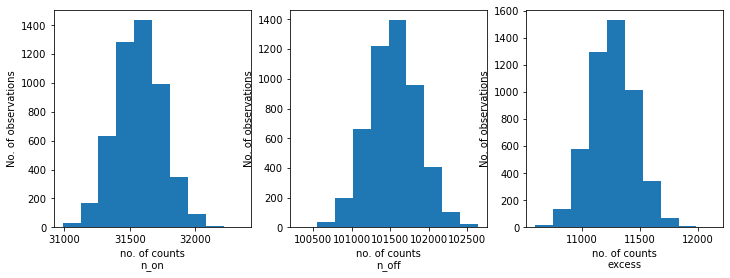

In [13]:

n_on = [dataset.counts.data.sum() for dataset in datasets]
n_off = [dataset.counts_off.data.sum() for dataset in datasets]
excess = [dataset.excess.data.sum() for dataset in datasets]

fix, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].hist(n_on)
axes[0].set_xlabel("no. of counts\nn_on")
axes[0].set_ylabel("No. of observations")
axes[1].hist(n_off)
axes[1].set_xlabel("no. of counts\nn_off")
axes[1].set_ylabel("No. of observations")
axes[2].hist(excess)
axes[2].set_xlabel("no. of counts\nexcess");
axes[2].set_ylabel("No. of observations")

In [14]:

%%time
results = []
for dataset in datasets:
    dataset.models = model.copy()
    fit = Fit([dataset])
    result = fit.optimize()
    results.append(
        {
            "index": result.parameters["index"].value,
            "amplitude": result.parameters["amplitude"].value,
            "lambda_": result.parameters["lambda_"].value,
        }
    )

CPU times: user 13min 47s, sys: 2.13 s, total: 13min 49s
Wall time: 13min 49s


In [15]:
results

[{'index': 2.2277014890350046,
  'amplitude': 1.2361699597883032e-12,
  'lambda_': 0.8771913199199592},
 {'index': 2.256141939366527,
  'amplitude': 1.1592170018498003e-12,
  'lambda_': 0.9123668648988691},
 {'index': 2.2673187750347403,
  'amplitude': 1.164801174921426e-12,
  'lambda_': 0.9770119045607368},
 {'index': 2.204478662830411,
  'amplitude': 1.3707461586045393e-12,
  'lambda_': 1.1180169016820818},
 {'index': 2.162123369183518,
  'amplitude': 1.4941489960213284e-12,
  'lambda_': 1.149481269135693},
 {'index': 2.16195812798937,
  'amplitude': 1.4656723948010833e-12,
  'lambda_': 1.1630444804572702},
 {'index': 2.247214118644901,
  'amplitude': 1.2213017496185367e-12,
  'lambda_': 0.9388338034853017},
 {'index': 2.221837157834904,
  'amplitude': 1.2866730136361347e-12,
  'lambda_': 0.9936044166833219},
 {'index': 2.213182287647928,
  'amplitude': 1.2811266719895797e-12,
  'lambda_': 0.983066055358285},
 {'index': 2.2502531549190885,
  'amplitude': 1.1879297852981216e-12,
  'la

index: 2.2188131904809714 += 0.03269495348833529


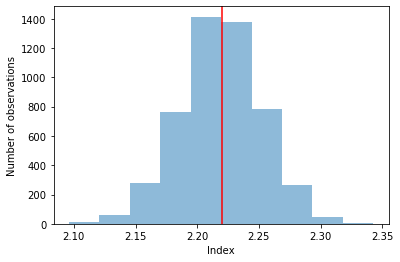

In [16]:
index = np.array([_["index"] for _ in results])
plt.hist(index, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["index"].value, color="red")
plt.xlabel("Index")
plt.ylabel("Number of observations")
print(f"index: {index.mean()} += {index.std()}")

amplitude: 1.296317396615242e-12 += 1.0236977920407e-13


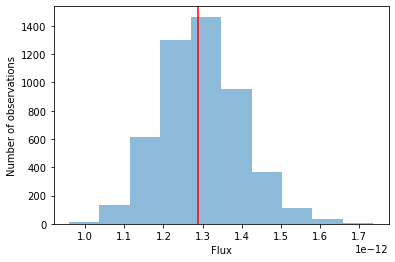

In [17]:
amplitude = np.array([_["amplitude"] for _ in results])
plt.hist(amplitude, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["amplitude"].value, color="red")
plt.xlabel("Flux")
plt.ylabel("Number of observations")
print(f"amplitude: {amplitude.mean()} += {amplitude.std()}")

lambda_: 1.0033103741050233 += 0.08170585598819732


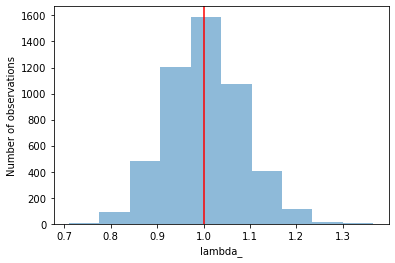

In [18]:
lambda_ = np.array([_["lambda_"] for _ in results])
plt.hist(lambda_, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["lambda_"].value, color="red")
plt.xlabel("lambda_")
plt.ylabel("Number of observations")
print(f"lambda_: {lambda_.mean()} += {lambda_.std()}")